In [1]:
#Load the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#load the helping functions
from pipeline_functions import replace_inf_with_nans, standadize_cols_per_subject, replace_with_nan
from pipeline_functions import impute_per_subject,replace_with_ceiling, feature_expansion, get_feature_matrix_with_labels

In [2]:
#Load the data and drop the left pupil
subjects_with_conditions_df = pd.read_csv('../subjects_with_conditions_df.csv').drop('Unnamed: 0', axis = 1).drop('left_pupil', axis = 1)

In [3]:
subjects_with_conditions_df.loc[subjects_with_conditions_df['subject']== 1009]

,subject,sample,time,trial,currentobject,rt,right_pupil,right_gaze_x,right_gaze_y,left_gaze_x,left_gaze_y,goal,feedback,reward,bi_goal,bi_feedback,bi_reward,tir_goal,tir_reward,label_7
23740107,1009,1,260392,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740108,1009,2,260401,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740109,1009,3,260408,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740110,1009,4,260418,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740111,1009,5,260425,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23925469,1009,185363,2010282,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23925470,1009,185364,2010290,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23925471,1009,185365,2010299,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23925472,1009,185366,2010307,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3


In [4]:
#remove subject 1009 since it has 60% broken trials
subjects_with_conditions_df = subjects_with_conditions_df.loc[subjects_with_conditions_df['subject']!= 1009]
subjects_with_conditions_df1 = subjects_with_conditions_df.loc[subjects_with_conditions_df['currentobject']== "Fixation"]

In [5]:
#Data curation- use the ceiling value for RT and gazes to limit high values

ceiling_df = replace_with_ceiling(subjects_with_conditions_df1)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [6]:
#Feature engineering - Adding the Deviation feature to the df

ceiling_df['RDEV'] = np.sqrt((ceiling_df['right_gaze_x'] - .5)**2 + (ceiling_df['right_gaze_y'] - .5)**2) 
ceiling_df['LDEV'] = np.sqrt((ceiling_df['left_gaze_x'] - .5)**2 + (ceiling_df['left_gaze_y'] - .5)**2) 

<ipython-input-6-93a0e21d90d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceiling_df['RDEV'] = np.sqrt((ceiling_df['right_gaze_x'] - .5)**2 + (ceiling_df['right_gaze_y'] - .5)**2)
<ipython-input-6-93a0e21d90d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceiling_df['LDEV'] = np.sqrt((ceiling_df['left_gaze_x'] - .5)**2 + (ceiling_df['left_gaze_y'] - .5)**2)


In [7]:
#Feature engineering- Taking means and variances

FE_df =  ceiling_df.groupby(['subject', 'trial']).agg({'right_pupil': ['mean', 'var'], 'LDEV': ['mean', 'var'], 
                                                       'RDEV': ['mean', 'var'],'rt': 'mean' }).reset_index()

In [8]:
FE_df

subject trial right_pupil                LDEV                RDEV  \
                           mean       var      mean       var      mean   
0         845     2    3.731641  0.009510  0.139242  0.001787  0.143712   
1         845     3    3.315353  0.018613  0.147356  0.000508  0.184631   
2         845     4    3.442791  0.003598  0.138801  0.000818  0.135075   
3         845     5    3.177231  0.071958  0.138625  0.000740  0.154326   
4         845     6    3.108376  0.089420  0.153853  0.014132  0.308680   
...       ...   ...         ...       ...       ...       ...       ...   
47009    1246   136    2.729606  0.005430  0.063321  0.000897  0.067020   
47010    1246   137    2.745854  0.004516  0.067167  0.000824  0.050996   
47011    1246   138    2.911762  0.007123  0.060284  0.001404  0.049063   
47012    1246   139    2.831226  0.009292  0.083413  0.001466  0.047057   
47013    1246   140    2.970614  0.030549  0.077364  0.001614  0.048353   

                  rt  
            var mean  
0      0.001325  369  
1      0.000522  336  
2      0.000936  300  
3      0.007994  308  
4      0.012724  354  
...         ...  ...  
47009  0.000299  404  
47010  0.000176  341  
47011  0.000773  298  
47012  0.000743  388  
47013  0.001340  324  

[47014 rows x 9 columns]

In [1]:
# Data imputation

imputed_df = impute_per_subject(FE_df)

NameError: name 'impute_per_subject' is not defined

In [10]:
#Data standardization. This is done per subject

standardized_df = standadize_cols_per_subject(imputed_df)


/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/Population regression/pipeline_functions.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df[columns[j]] = scaler.fit_transform(subject_df[columns[j]].values.reshape(-1,1))
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/Population regression/pipeline_functions.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [11]:
standardized_df

subject     trial right_pupil                LDEV                RDEV  \
                             mean       var      mean       var      mean   
0     845.0  0.000000    0.684889  0.041297  0.208860  0.009611  0.320946   
1     845.0  0.007246    0.384040  0.094138  0.233713  0.002546  0.427909   
2     845.0  0.014493    0.476139  0.006983  0.207510  0.004259  0.298369   
3     845.0  0.021739    0.284220  0.403793  0.206968  0.003825  0.348690   
4     845.0  0.028986    0.234458  0.505157  0.253613  0.077818  0.752174   
..      ...       ...         ...       ...       ...       ...       ...   
128  1246.0  0.971223    0.362301  0.050061  0.019115  0.002536  0.028477   
129  1246.0  0.978417    0.379193  0.039489  0.023144  0.002303  0.014988   
130  1246.0  0.985612    0.551681  0.069650  0.015934  0.004154  0.013361   
131  1246.0  0.992806    0.467952  0.094740  0.040160  0.004354  0.011672   
132  1246.0  1.000000    0.612868  0.340627  0.033825  0.004824  0.012763   

                  rt  
          var   mean  
0    0.015144  369.0  
1    0.005727  336.0  
2    0.010577  300.0  
3    0.093310  308.0  
4    0.148750  354.0  
..        ...    ...  
128  0.000785  404.0  
129  0.000420  341.0  
130  0.002202  298.0  
131  0.002112  388.0  
132  0.003899  324.0  

[47014 rows x 9 columns]

In [12]:
#rename cols
cols = ['subject', 'trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'rt']
standardized_df.columns = cols

In [13]:
#standardized_df.to_excel("standardized_df.xlsx")

In [14]:
#Add back the exp conditions

df_with_labels = get_feature_matrix_with_labels(subjects_with_conditions_df, standardized_df)

In [15]:
df_with_labels

,subject,trial_no,mean_DIAM,var_DIAM,mean_LDEV,var_LDEV,mean_RDEV,var_RDEV,rt,goal,feedback,reward
0,845.0,0.000000,0.684889,0.041297,0.208860,0.009611,0.320946,0.015144,369.0,2,0,0
1,845.0,0.007246,0.384040,0.094138,0.233713,0.002546,0.427909,0.005727,336.0,2,0,0
2,845.0,0.014493,0.476139,0.006983,0.207510,0.004259,0.298369,0.010577,300.0,2,0,0
3,845.0,0.021739,0.284220,0.403793,0.206968,0.003825,0.348690,0.093310,308.0,2,0,0
4,845.0,0.028986,0.234458,0.505157,0.253613,0.077818,0.752174,0.148750,354.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
128,1246.0,0.971223,0.362301,0.050061,0.019115,0.002536,0.028477,0.000785,404.0,2,1,0
129,1246.0,0.978417,0.379193,0.039489,0.023144,0.002303,0.014988,0.000420,341.0,2,1,0
130,1246.0,0.985612,0.551681,0.069650,0.015934,0.004154,0.013361,0.002202,298.0,2,1,0
131,1246.0,0.992806,0.467952,0.094740,0.040160,0.004354,0.011672,0.002112,388.0,2,1,0


In [16]:
# Dummy enconding for subject, goal and reward

feature_encoded_df = pd.get_dummies(data= df_with_labels, columns=[ 'goal', 'reward', 'subject'], drop_first= True)
#feature_encoded_df = pd.get_dummies(data= df_with_labels, columns=[ 'goal', 'reward'], drop_first= True)

In [17]:
feature_encoded_df

,trial_no,mean_DIAM,var_DIAM,mean_LDEV,var_LDEV,mean_RDEV,var_RDEV,rt,feedback,goal_1,...,subject_1237.0,subject_1238.0,subject_1239.0,subject_1240.0,subject_1241.0,subject_1242.0,subject_1243.0,subject_1244.0,subject_1245.0,subject_1246.0
0,0.000000,0.684889,0.041297,0.208860,0.009611,0.320946,0.015144,369.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.007246,0.384040,0.094138,0.233713,0.002546,0.427909,0.005727,336.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.014493,0.476139,0.006983,0.207510,0.004259,0.298369,0.010577,300.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.021739,0.284220,0.403793,0.206968,0.003825,0.348690,0.093310,308.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.028986,0.234458,0.505157,0.253613,0.077818,0.752174,0.148750,354.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.971223,0.362301,0.050061,0.019115,0.002536,0.028477,0.000785,404.0,1,0,...,0,0,0,0,0,0,0,0,0,1
129,0.978417,0.379193,0.039489,0.023144,0.002303,0.014988,0.000420,341.0,1,0,...,0,0,0,0,0,0,0,0,0,1
130,0.985612,0.551681,0.069650,0.015934,0.004154,0.013361,0.002202,298.0,1,0,...,0,0,0,0,0,0,0,0,0,1
131,0.992806,0.467952,0.094740,0.040160,0.004354,0.011672,0.002112,388.0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
import pandas as pd
import statsmodels.api as sm


def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


# P3 all features

In [20]:
df = feature_encoded_df
P3_list = []
features = []

X= df.drop(['rt'], axis =1) 
y= df ['rt']


#Feature selection
feature_support = backward_regression(X, y, threshold_out = 0.9)
features.append(feature_support)

X_1 = X.get(feature_support)


#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Regression
%load_ext line_profiler

cv_df_list = []
random_state = [42, 35, 20, 50, 22]
for i in range(5): #This is for manual cv
    X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2, random_state= random_state[i])
    reg = Regression(verbose=0,ignore_warnings=True, custom_metric= None)
    models, predictions = reg.fit( X_train, X_test, y_train, y_test)
    cv_df_list.append(models.drop(['Adjusted R-Squared', 'RMSE', 'Time Taken'], axis = 1).rename(columns={'R-Squared':str(i)}))
#get the resulting concat df
concat_df = pd.concat(cv_df_list, axis=1) #concats the results of the lazy predict for each iteration for the subject
concat_df['R-Squared'] =  concat_df.median(axis=1)#creates a new column with median of the methods    
P3_list.append(concat_df)


100%|██████████| 41/41 [32:26<00:00, 47.48s/it]   


In [30]:
X.shape

(47014, 360)

In [21]:
concat_df

,0,1,2,3,4,R-Squared
Model,,,,,,
MLPRegressor,0.24,0.25,0.24,0.25,0.26,0.25
LGBMRegressor,0.22,0.24,0.24,0.22,0.25,0.24
SGDRegressor,0.21,0.22,0.22,0.23,0.24,0.22
BayesianRidge,0.21,0.22,0.22,0.23,0.24,0.22
Ridge,0.21,0.22,0.22,0.22,0.24,0.22
RidgeCV,0.21,0.22,0.22,0.22,0.24,0.22
LassoLarsCV,0.21,0.22,0.22,0.22,0.24,0.22
TransformedTargetRegressor,0.21,0.22,0.22,0.22,0.24,0.22
LinearRegression,0.21,0.22,0.22,0.22,0.24,0.22


In [ ]:
P3_list[0].to_excel("P3_list_with_subject.xlsx")

In [25]:
len(features[0])

343

In [27]:
models.to_excel("P3.xlsx")

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
reg = MLPRegressor()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
cv_results = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'r2')
cv_results['test_score'].mean()

0.24753791335773048

In [29]:
from sklearn.metrics import mean_squared_error

cv_results2 = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'neg_mean_squared_error' )

splits = [(x,y) for x, y in cv.split(X_1, y)] #This gives the train and test arrays 
n_train_samples = len(splits[0][0]) #this will give the train sample length.
n_test_samples = len(splits[0][1]) #this will give the train sample length.
#Here the first 0 provides the train test indices of the first cv. The second 0 is to get train indices. 
#Change the second 0 to 1 to get the idices of the training set of the first cv iteration
SSE = abs(cv_results2['test_score']*n_test_samples)
aic = 2*X_1.shape[1] + n_train_samples*np.log(SSE/ n_train_samples)
aic

array([274208.07373066, 271291.00553117, 272954.09448044, 274478.7424932 ,
       271475.38948476, 272923.30869267])

In [30]:
from statistics import mean
aic_mean = mean(aic)
aic_mean

272888.4357354828

In [31]:
features_P3 = features

In [32]:
#Saving the features
features_P3 = np.save('features_P3', features_P3, allow_pickle=True, fix_imports=True)

In [34]:
features

[['trial_no',
  'mean_DIAM',
  'var_DIAM',
  'mean_LDEV',
  'var_LDEV',
  'mean_RDEV',
  'var_RDEV',
  'feedback',
  'goal_1',
  'goal_2',
  'reward_1',
  'subject_846.0',
  'subject_847.0',
  'subject_848.0',
  'subject_849.0',
  'subject_850.0',
  'subject_851.0',
  'subject_852.0',
  'subject_853.0',
  'subject_854.0',
  'subject_855.0',
  'subject_856.0',
  'subject_857.0',
  'subject_858.0',
  'subject_859.0',
  'subject_861.0',
  'subject_862.0',
  'subject_863.0',
  'subject_864.0',
  'subject_865.0',
  'subject_866.0',
  'subject_867.0',
  'subject_868.0',
  'subject_869.0',
  'subject_870.0',
  'subject_871.0',
  'subject_872.0',
  'subject_874.0',
  'subject_875.0',
  'subject_876.0',
  'subject_877.0',
  'subject_878.0',
  'subject_879.0',
  'subject_880.0',
  'subject_881.0',
  'subject_882.0',
  'subject_883.0',
  'subject_884.0',
  'subject_885.0',
  'subject_887.0',
  'subject_888.0',
  'subject_889.0',
  'subject_890.0',
  'subject_892.0',
  'subject_893.0',
  'subject_

# P4 with no subject ID

In [36]:
#Create the correct df for P4

columns = ['trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV',
       'mean_RDEV', 'var_RDEV', 'feedback', 'goal_1', 'goal_2', 'reward_1', 'reward_2','rt' ]
P4_df = feature_encoded_df[columns]

In [37]:
P4_df

,trial_no,mean_DIAM,var_DIAM,mean_LDEV,var_LDEV,mean_RDEV,var_RDEV,feedback,goal_1,goal_2,reward_1,reward_2,rt
0,0.00,0.68,0.04,0.21,0.01,0.32,0.02,0,0,1,0,0,369.00
1,0.01,0.38,0.09,0.23,0.00,0.43,0.01,0,0,1,0,0,336.00
2,0.01,0.48,0.01,0.21,0.00,0.30,0.01,0,0,1,0,0,300.00
3,0.02,0.28,0.40,0.21,0.00,0.35,0.09,0,0,1,0,0,308.00
4,0.03,0.23,0.51,0.25,0.08,0.75,0.15,0,0,1,0,0,354.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.97,0.36,0.05,0.02,0.00,0.03,0.00,1,0,1,0,0,404.00
129,0.98,0.38,0.04,0.02,0.00,0.01,0.00,1,0,1,0,0,341.00
130,0.99,0.55,0.07,0.02,0.00,0.01,0.00,1,0,1,0,0,298.00
131,0.99,0.47,0.09,0.04,0.00,0.01,0.00,1,0,1,0,0,388.00


In [38]:
P33_list = []
features = []

X= P4_df.drop(['rt'], axis =1) 
y= P4_df ['rt']


#Feature selection
feature_support = backward_regression(X, y, threshold_out = 0.05)
features.append(feature_support)
X_1 = X.get(feature_support)

#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Regression
%load_ext line_profiler

cv_df_list = []
random_state = [42, 35, 20, 50, 22]
for i in range(5): #This is for manual cv
    X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2, random_state= random_state[i])
    reg = Regression(verbose=0,ignore_warnings=True, custom_metric= None)
    models, predictions = reg.fit( X_train, X_test, y_train, y_test)
    cv_df_list.append(models.drop(['Adjusted R-Squared', 'RMSE', 'Time Taken'], axis = 1).rename(columns={'R-Squared':str(i)}))
#get the resulting concat df
concat_df = pd.concat(cv_df_list, axis=1) #concats the results of the lazy predict for each iteration for the subject
concat_df['R-Squared'] =  concat_df.median(axis=1)#creates a new column with median of the methods    
P33_list.append(concat_df)


  0%|          | 0/41 [00:00<?, ?it/s]

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


100%|██████████| 41/41 [06:06<00:00,  8.94s/it]


In [39]:
P33_list[0].to_excel("P3_list_without_subject.xlsx")

In [41]:
concat_df

,0,1,2,3,4,R-Squared
Model,,,,,,
MLPRegressor,0.04,0.04,0.04,0.04,0.04,0.04
PoissonRegressor,0.03,0.03,0.04,0.04,0.04,0.04
OrthogonalMatchingPursuitCV,0.03,0.03,0.04,0.04,0.04,0.04
ElasticNetCV,0.03,0.03,0.04,0.04,0.04,0.04
BayesianRidge,0.03,0.03,0.04,0.04,0.04,0.04
SGDRegressor,0.03,0.03,0.04,0.04,0.04,0.04
RidgeCV,0.03,0.03,0.04,0.04,0.04,0.04
LassoCV,0.03,0.03,0.04,0.04,0.04,0.04
Ridge,0.03,0.03,0.04,0.04,0.04,0.04


In [42]:
len(features[0])

9

In [43]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
reg = MLPRegressor()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
cv_results = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'r2')
cv_results['test_score'].mean()

0.037339362412954026

In [44]:
from sklearn.metrics import mean_squared_error

cv_results2 = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'neg_mean_squared_error' )

splits = [(x,y) for x, y in cv.split(X_1, y)] #This gives the train and test arrays 
n_train_samples = len(splits[0][0]) #this will give the train sample length.
n_test_samples = len(splits[0][1]) #this will give the train sample length.
#Here the first 0 provides the train test indices of the first cv. The second 0 is to get train indices. 
#Change the second 0 to 1 to get the idices of the training set of the first cv iteration
SSE = abs(cv_results2['test_score']*n_test_samples)
aic = 2*X_1.shape[1] + n_train_samples*np.log(SSE/ n_train_samples)
from statistics import mean
aic_mean = mean(aic)
aic_mean

279952.044950181

In [45]:
#saving the features
features_P4 = features
features_P4 = np.save('features_P4', features_P4, allow_pickle=True, fix_imports=True)

In [46]:
features

[['trial_no',
  'mean_DIAM',
  'var_DIAM',
  'var_LDEV',
  'mean_RDEV',
  'feedback',
  'goal_1',
  'goal_2',
  'reward_1']]

# P2 no exp. conditions

In [47]:
df = feature_encoded_df
features = []

X= df.drop(['rt','feedback','goal_1', 'goal_2', 'reward_1', 'reward_2'], axis =1) 
y= df ['rt']

#Feature selection
feature_support = backward_regression(X, y, threshold_out = 0.05)
features.append(feature_support)
X_1 = X.get(feature_support)

#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Regression
%load_ext line_profiler



cv_df_list = []
random_state = [42, 35, 20, 50, 22]
for i in range(5): #This is for manual cv
    X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2, random_state= random_state[i])
    reg = Regression(verbose=0,ignore_warnings=True, custom_metric= None)
    models, predictions = reg.fit( X_train, X_test, y_train, y_test)
    cv_df_list.append(models.drop(['Adjusted R-Squared', 'RMSE', 'Time Taken'], axis = 1).rename(columns={'R-Squared':str(i)}))
#get the resulting concat df
concat_df = pd.concat(cv_df_list, axis=1) #concats the results of the lazy predict for each iteration for the subject
concat_df['R-Squared'] =  concat_df.median(axis=1)#creates a new column with median of the methods    

  0%|          | 0/41 [00:00<?, ?it/s]

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


100%|██████████| 41/41 [33:56<00:00, 49.68s/it]   


In [48]:
concat_df

,0,1,2,3,4,R-Squared
Model,,,,,,
MLPRegressor,0.24,0.25,0.24,0.25,0.26,0.25
HistGradientBoostingRegressor,0.22,0.25,0.23,0.22,0.24,0.23
LGBMRegressor,0.22,0.25,0.24,0.22,0.26,0.24
SGDRegressor,0.21,0.22,0.22,0.23,0.24,0.22
BayesianRidge,0.21,0.22,0.22,0.23,0.24,0.22
Ridge,0.21,0.22,0.22,0.22,0.24,0.22
RidgeCV,0.21,0.22,0.22,0.22,0.24,0.22
LassoLarsIC,0.21,0.22,0.22,0.22,0.24,0.22
LassoLarsCV,0.21,0.22,0.22,0.22,0.24,0.22


In [49]:
len(features[0])

237

In [50]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
reg = MLPRegressor()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
cv_results = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'r2')
cv_results['test_score'].mean()

0.24818611062303822

In [51]:
from sklearn.metrics import mean_squared_error

cv_results2 = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'neg_mean_squared_error' )

splits = [(x,y) for x, y in cv.split(X_1, y)] #This gives the train and test arrays 
n_train_samples = len(splits[0][0]) #this will give the train sample length.
n_test_samples = len(splits[0][1]) #this will give the train sample length.
#Here the first 0 provides the train test indices of the first cv. The second 0 is to get train indices. 
#Change the second 0 to 1 to get the idices of the training set of the first cv iteration
SSE = abs(cv_results2['test_score']*n_test_samples)
aic = 2*X_1.shape[1] + n_train_samples*np.log(SSE/ n_train_samples)
from statistics import mean
aic_mean = mean(aic)
aic_mean

272657.6084748637

In [52]:
#saving the features
features_P2 = features
features_P2 = np.save('features_P2', features_P2, allow_pickle=True, fix_imports=True)

# P1 only subject IDs

In [20]:
df = feature_encoded_df
features = []


X= df.drop(['rt','feedback','goal_1', 'goal_2', 'reward_1', 'reward_2', 'mean_DIAM','var_DIAM','mean_LDEV','var_LDEV', 'mean_RDEV','var_RDEV'], axis =1)
y= df ['rt']

#Feature selection
feature_support = backward_regression(X, y, threshold_out = 0.05)
features.append(feature_support)
X_1 = X.get(feature_support)


#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Regression
%load_ext line_profiler

cv_df_list = []
random_state = [42, 35, 20, 50, 22]
for i in range(5): #This is for manual cv
    X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2, random_state= random_state[i])
    reg = Regression(verbose=0,ignore_warnings=True, custom_metric= None)
    models, predictions = reg.fit( X_train, X_test, y_train, y_test)
    cv_df_list.append(models.drop(['Adjusted R-Squared', 'RMSE', 'Time Taken'], axis = 1).rename(columns={'R-Squared':str(i)}))
#get the resulting concat df
concat_df = pd.concat(cv_df_list, axis=1) #concats the results of the lazy predict for each iteration for the subject
concat_df['R-Squared'] =  concat_df.median(axis=1)#creates a new column with median of the methods    


100%|██████████| 41/41 [28:44<00:00, 42.05s/it]   


In [21]:
concat_df

,0,1,2,3,4,R-Squared
Model,,,,,,
GaussianProcessRegressor,0.25,0.26,0.21,0.26,0.26,0.26
LGBMRegressor,0.23,0.23,0.23,0.23,0.26,0.23
HistGradientBoostingRegressor,0.23,0.24,0.23,0.23,0.25,0.23
SGDRegressor,0.21,0.22,0.21,0.23,0.24,0.22
BayesianRidge,0.21,0.22,0.22,0.22,0.24,0.22
MLPRegressor,0.21,0.22,0.23,0.24,0.24,0.23
Ridge,0.21,0.22,0.22,0.22,0.24,0.22
TransformedTargetRegressor,0.21,0.22,0.22,0.22,0.24,0.22
LinearRegression,0.21,0.22,0.22,0.22,0.24,0.22


In [ ]:
models.to_excel("P1.xlsx")

In [22]:
len(features[0])

232

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.gaussian_process import GaussianProcessRegressor
reg = MLPRegressor()
#reg = GaussianProcessRegressor()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
cv_results = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'r2')
cv_results['test_score'].mean()

0.23582494533344497

In [24]:
from sklearn.metrics import mean_squared_error

cv_results2 = cross_validate(reg, X_1, y, cv=cv, return_estimator=True, scoring= 'neg_mean_squared_error' )

splits = [(x,y) for x, y in cv.split(X_1, y)] #This gives the train and test arrays 
n_train_samples = len(splits[0][0]) #this will give the train sample length.
n_test_samples = len(splits[0][1]) #this will give the train sample length.
#Here the first 0 provides the train test indices of the first cv. The second 0 is to get train indices. 
#Change the second 0 to 1 to get the idices of the training set of the first cv iteration
SSE = abs(cv_results2['test_score']*n_test_samples)
aic = 2*X_1.shape[1] + n_train_samples*np.log(SSE/ n_train_samples)
from statistics import mean
aic_mean = mean(aic)
aic_mean

273083.41180621204

In [26]:
#saving the features
features_P1 = features
features_P1 = np.save('features_P1', features_P1, allow_pickle=True, fix_imports=True)

we used lazy to ensure that linear reg. is one of the tops. Then for simplicity, we do all other analysis using linear regression. No need to do manual CV in lazy since the results are the same with or without manual 5 CVs in lazy.

# Boxplots

In [29]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

df =  feature_encoded_df

X1= df.drop(['rt','feedback','goal_1', 'goal_2', 'reward_1', 'reward_2', 'mean_DIAM','var_DIAM','mean_LDEV','var_LDEV', 'mean_RDEV','var_RDEV'], axis =1)
X2= df.drop(['rt','feedback','goal_1', 'goal_2', 'reward_1', 'reward_2'], axis =1) 
X3= df.drop(['rt'], axis =1) 
X4 = df[['feedback','goal_1', 'goal_2', 'reward_1', 'reward_2','trial_no', 'mean_DIAM','var_DIAM','mean_LDEV','var_LDEV', 'mean_RDEV','var_RDEV']]


y= df['rt']

feature_df_list = [X1,X2,X3,X4]
results = []

for i in range(4):
    X = feature_df_list[i]
    cv = RepeatedKFold(n_splits=20, n_repeats=20, random_state=1)
    
    model = MLPRegressor().fit(X, y)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1) #this is an array of 30 r2s
    results.append(scores)

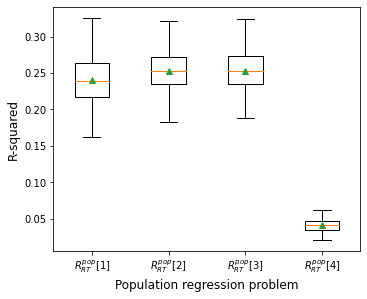

In [32]:
from matplotlib import pyplot
labels = ['$R_{RT}^{pop}[1]$', '$R_{RT}^{pop}[2]$', '$R_{RT}^{pop}[3]$', '$R_{RT}^{pop}[4]$']
# plot the results
pyplot.boxplot(results, labels=[str(r) for r in labels ], showmeans=True, showfliers=False)

# Add title and axis names
fig = pyplot.gcf()
fig.set_size_inches(5.5, 4.5)
pyplot.ylabel("R-squared", fontsize=12)
pyplot.xlabel("Population regression problem", fontsize=12)
#pyplot.title("R-square")
pyplot.savefig('Boxplots for population problems.pdf')
pyplot.show()

# Scratch

In [ ]:
#get the means of the three problems
from statistics import mean
mean_list= []
std_list = []
for i in range(4):
    mean_list.append(np.mean(results[i]))
    std_list.append(np.std(results[i]))
    
mean_list

In [ ]:
std_list

In [ ]:
df

In [ ]:
# Feature importance P3
from sklearn.linear_model import LinearRegression
X= df.drop(['rt'], axis =1) 
y= df['rt']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LinearRegression().fit(X, y)
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
importance = model.coef_


In [ ]:
pyplot.bar([x for x in range(len(importance))], abs(importance))

fig = pyplot.gcf()
fig.set_size_inches(8.5, 6.5)
#extraticks=[303]
#pyplot.xticks(list(pyplot.xticks()[0]) + extraticks, rotation=90, fontsize=5)
pyplot.xlim([0, 361])
pyplot.ylabel("Absolute value of coefficients")
pyplot.xlabel("Feature numbers")
#pyplot.title("R-square")
pyplot.savefig('Feature importance for population.pdf')
pyplot.show()

In [ ]:
pyplot.bar([x for x in range(len(importance))], abs(importance))
fig = pyplot.gcf()
fig.set_size_inches(8.5, 6.5)
#extraticks=[303]
#pyplot.xticks(list(pyplot.xticks()[0]) + extraticks, rotation=90, fontsize=5)
pyplot.xlim([0, 15])
pyplot.ylabel("Absolute value of coefficients")
pyplot.xlabel("Feature numbers")
#pyplot.title("R-square")
pyplot.savefig('Feature importance for population2.pdf')
pyplot.show()

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

df =  feature_encoded_df

X1= df.drop(['rt','feedback','goal_1', 'goal_2', 'reward_1', 'reward_2', 'mean_DIAM','var_DIAM','mean_LDEV','var_LDEV', 'mean_RDEV','var_RDEV'], axis =1)
X2= df.drop(['rt','feedback','goal_1', 'goal_2', 'reward_1', 'reward_2'], axis =1) 
X3= df.drop(['rt'], axis =1) 
X4 = df[['feedback','goal_1', 'goal_2', 'reward_1', 'reward_2','trial_no', 'mean_DIAM','var_DIAM','mean_LDEV','var_LDEV', 'mean_RDEV','var_RDEV']]


y= df['rt']

feature_df_list = [X1,X2,X3,X4]


In [ ]:
# Feature importance P2
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
X= X2
y= df['rt']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LinearRegression().fit(X, y)
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
importance = model.coef_

pyplot.bar([x for x in range(len(importance))], abs(importance))

fig = pyplot.gcf()
fig.set_size_inches(8.5, 6.5)
#extraticks=[303]
#pyplot.xticks(list(pyplot.xticks()[0]) + extraticks, rotation=90, fontsize=5)
#pyplot.xlim([0, 361])
pyplot.ylabel("Absolute value of coefficients")
pyplot.xlabel("Feature numbers")
#pyplot.title("R-square")
#pyplot.savefig('Feature importance for population.pdf')
pyplot.show()

In [ ]:
# Feature importance P1
from sklearn.linear_model import LinearRegression
X= X1
y= df['rt']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LinearRegression().fit(X, y)
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
importance = model.coef_

pyplot.bar([x for x in range(len(importance))], abs(importance))

fig = pyplot.gcf()
fig.set_size_inches(8.5, 6.5)
#extraticks=[303]
#pyplot.xticks(list(pyplot.xticks()[0]) + extraticks, rotation=90, fontsize=5)
pyplot.xlim([0, 361])
pyplot.ylabel("Absolute value of coefficients")
pyplot.xlabel("Feature numbers")
#pyplot.title("R-square")
#pyplot.savefig('Feature importance for population.pdf')
pyplot.show()

In [ ]:
# Feature importance P4
from sklearn.linear_model import LinearRegression
X= X4
y= df['rt']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LinearRegression().fit(X, y)
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
importance = model.coef_

pyplot.bar([x for x in range(len(importance))], abs(importance))

fig = pyplot.gcf()
fig.set_size_inches(8.5, 6.5)
#extraticks=[303]
#pyplot.xticks(list(pyplot.xticks()[0]) + extraticks, rotation=90, fontsize=5)
#pyplot.xlim([0, 361])
pyplot.ylabel("Absolute value of coefficients")
pyplot.xlabel("Feature numbers")
#pyplot.title("R-square")
#pyplot.savefig('Feature importance for population.pdf')
pyplot.show()

In [ ]:
X4